In [1]:
import os

Step1: extract lines containing p-values

In [2]:
rootdir = './smallcrush/'
subdirs = [ f.path + '/' for f in os.scandir(rootdir) if f.is_dir() ]

In [3]:
path = './pval/'
os.mkdir(path)

for subdir in subdirs:
    seed = subdir[len(rootdir):]
    os.mkdir(path + seed)
    
    for file in os.listdir(subdir):
        open(path + seed + file, 'w').writelines(line for line in open(subdir + file) if 'p-value' in line)

Step2: extract p-values from those lines

In [4]:
rootdir = './pval/'
subdirs = [ f.path + '/' for f in os.scandir(rootdir) if f.is_dir() ]

In [5]:
path = './pval_clean/'
os.mkdir(path)
sep = '*'

for subdir in subdirs:
    seed = subdir[len(rootdir):]
    os.mkdir(path + seed)
    
    for file in os.listdir(subdir):
        with open(subdir + file, 'r') as fin:
            head = [next(fin) for x in range(15)]
            for i in range(len(head)):
                head[i] = head[i][len('p-value of test                       :'):].split(sep, 1)[0].strip()
            with open(path + seed + file, 'w') as fout:
                for item in head:
                    if item == 'eps':
                        item = '0.00'
                    # elif item == '1 - eps1':
                    elif '1 - ' in item:
                        item = '1.00'
                    fout.write("%s\n" % item)

In [6]:
import numpy as np

from scipy.special import gammainc
from scipy.special import gamma

In [7]:
def CT_SingleUtil(pval, x, y):
    # STEP 1
    K = 10 # no. of sub-intervals
    S = np.zeros(K) # no. of sequences 

    for i in range(pval.shape[0]):
        px = pval[i][x]
        py = pval[i][y]
        dp = px - py
        for j in range(K):
            if -1 <= dp and dp <= (-1 + 2/K):
                S[0]+=1
            elif (-1 + 2*j/K) < dp and dp <= (-1 + 2*(j+1)/K):
                S[j]+=1
   
    # STEP 2
    P = np.array([0.02, 0.06, 0.1, 0.14, 0.18, 0.18, 0.14, 0.1, 0.06, 0.02])
    V = 0
    for i in range(K):
        V += ((S[i] - pval.shape[0]*P[i])**2) / (pval.shape[0]*P[i])
    
    # STEP 3
    # https://stackoverflow.com/a/38715054
    a = (K-1)/2
    x = V/2
    PT = gamma(a)*(1-gammainc(a,x))
    
    # STEP 4
    if(PT > 0.001):
        return 1
    else:
        return 0

Step3: CT_Single

In [8]:
def CT_Single(subdir):
    pval = np.array([np.genfromtxt(subdir + file) for file in os.listdir(subdir)])
    
    transform = lambda x: 0.5 - abs(x - 0.5)
    for i in range(pval.shape[0]):
        for j in range(pval.shape[1]):
            pval[i][j] = transform(pval[i][j])
    
    single_result = np.zeros((pval.shape[1], pval.shape[1]))
    for x in range(pval.shape[1]):
        for y in range(pval.shape[1]):
            single_result[x][y] = CT_SingleUtil(pval, x, y)   
    return single_result

Step4: CT_Total

In [9]:
def CT_Total(subdirs):
    total_result = np.zeros((15, 15))
    for subdir in subdirs:
        single_result = CT_Single(subdir)
        total_result = np.add(total_result, single_result)
    return total_result

Step5: Main

In [10]:
rootdir = './pval_clean/'
subdirs = [ f.path + '/' for f in os.scandir(rootdir) if f.is_dir() ]
total_result = CT_Total(subdirs)

In [11]:
np.savetxt("corr.csv", total_result, delimiter=",")

In [12]:
import pandas as pd
import seaborn as sns

In [13]:
test_names = ['smarsa_BirthdaySpacings', 
        'sknuth_Collision', 
        'sknuth_Gap', 
        'sknuth_SimpPoker', 
        'sknuth_CouponCollector', 
        'sknuth_MaxOft Chi-square statistic', 
        'sknuth_MaxOft Anderson-Darling statistic', 
        'svaria_WeightDistrib', 
        'smarsa_MatrixRank', 
        'sstring_HammingIndep', 
        'swalk_RandomWalk1 Statistic H', 
        'swalk_RandomWalk1 Statistic M', 
        'swalk_RandomWalk1 statistic J', 
        'swalk_RandomWalk1 Statistic R', 
        'swalk_RandomWalk1 Statistic C']
corr = pd.read_csv("corr.csv", names=test_names)
corr.index = test_names
corr

,smarsa_BirthdaySpacings,sknuth_Collision,sknuth_Gap,sknuth_SimpPoker,sknuth_CouponCollector,sknuth_MaxOft Chi-square statistic,sknuth_MaxOft Anderson-Darling statistic,svaria_WeightDistrib,smarsa_MatrixRank,sstring_HammingIndep,swalk_RandomWalk1 Statistic H,swalk_RandomWalk1 Statistic M,swalk_RandomWalk1 statistic J,swalk_RandomWalk1 Statistic R,swalk_RandomWalk1 Statistic C
smarsa_BirthdaySpacings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sknuth_Collision,0.0,0.0,54.0,74.0,33.0,0.0,52.0,86.0,63.0,50.0,56.0,54.0,54.0,57.0,58.0
sknuth_Gap,0.0,23.0,0.0,16.0,0.0,0.0,3.0,0.0,3.0,5.0,0.0,6.0,5.0,8.0,12.0
sknuth_SimpPoker,0.0,81.0,21.0,0.0,26.0,0.0,45.0,30.0,52.0,45.0,59.0,40.0,48.0,50.0,61.0
sknuth_CouponCollector,0.0,37.0,3.0,29.0,0.0,0.0,26.0,3.0,40.0,39.0,40.0,53.0,41.0,37.0,48.0
sknuth_MaxOft Chi-square statistic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sknuth_MaxOft Anderson-Darling statistic,0.0,55.0,4.0,51.0,31.0,0.0,0.0,6.0,36.0,40.0,30.0,30.0,34.0,43.0,43.0
svaria_WeightDistrib,0.0,82.0,0.0,22.0,3.0,0.0,6.0,0.0,2.0,2.0,6.0,10.0,8.0,8.0,13.0
smarsa_MatrixRank,0.0,66.0,4.0,65.0,43.0,0.0,36.0,4.0,0.0,38.0,61.0,53.0,65.0,54.0,57.0
sstring_HammingIndep,0.0,60.0,10.0,55.0,39.0,0.0,38.0,8.0,40.0,0.0,39.0,35.0,41.0,40.0,34.0


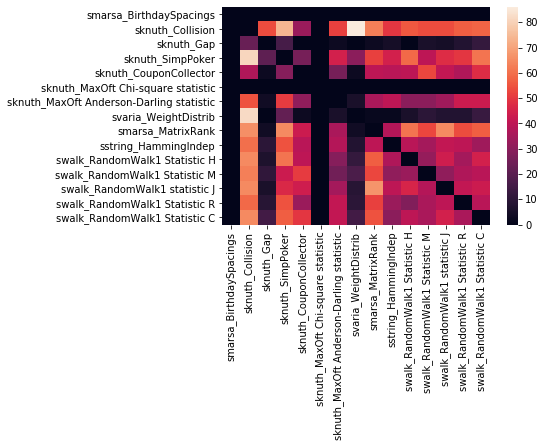

In [14]:
sns.heatmap(corr)